# Lec 22: Confidence Intervals & The Bootstrap - (Filled In Code) 
***

We'll need Numpy, Matplotlib, Pandas, and scipy.stats for this notebook, so let's load them. 

In [1]:
import numpy as np 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

import math

## Inference: Estimation

For this example we'll use a dataset of compensation for public employees in San Francisco in 2019.

In [2]:
sf = pd.read_csv('san_francisco_2019.csv')
sf.head()

,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
0,Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332.0,0.0,40059.0,131391.0
1,Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241.0,0.0,49279.0,172520.0
2,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715.0,0.0,46752.0,162468.0
3,Public Protection,Adult Probation,Information Systems,IS Business Analyst-Principal,159394.0,0.0,57312.0,216706.0
4,Public Protection,Adult Probation,Information Systems,IS Programmer Analyst,70035.0,0.0,28671.0,98706.0


Suppose we're interested in a histogram of the `Total Compensation` Distribution:

array([[<Axes: title={'center': 'Total Compensation'}>]], dtype=object)

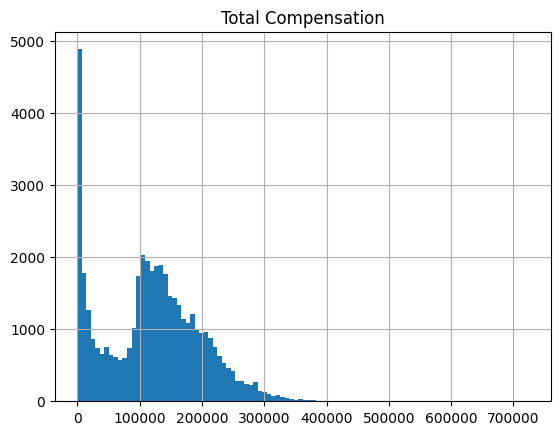

In [3]:
# Population Total Compensation Distribution 


sf.hist('Total Compensation', bins=100)

In [4]:
# Who made the most money
sf['Total Compensation'].sort_values(ascending=False).head()

43936    724031.0
43937    617951.0
43938    617554.0
43940    571784.0
43939    570235.0
Name: Total Compensation, dtype: float64

In [5]:
# Who made the least money
sf['Total Compensation'].sort_values().head()

18526    0.0
43234    0.0
22329    0.0
32865    0.0
38732    0.0
Name: Total Compensation, dtype: float64

Text(0.5, 0, 'Compensation ($)')

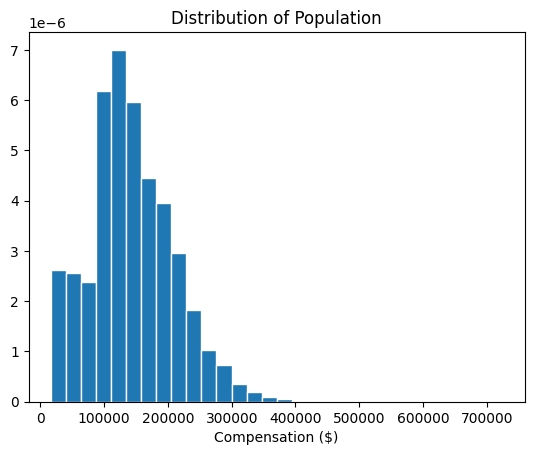

In [6]:
# We see a lot of outlier data with $0 compensation.  Let's filter this out for our analysis by using
# a cutoff of minimum salary.  Let's include people working at  minimum wage part-time:
# $15/hr, 20 hr/wk, 52 weeks
min_salary = 15 * 20 * 52
sf = sf[sf["Salary"]>=min_salary]

sf_bins = np.arange(0, 726000, 25000)



plt.hist(sf["Total Compensation"],density=True, ec='white', bins=30);
plt.title("Distribution of Population")
plt.xlabel("Compensation ($)")



### Defining the Statistic

Here we are interested in the median (50% percentile) of the total compensation. 

In [7]:
# Statistic: Median total compensation 
def median_comp(t):
    return t['Total Compensation'].median()

### The Population Parameter

We have access to the population so we can compute the **parameter** but in practice we typically won't have access to the population and instead we will have to *estimate* the parameter from a **sample**.

In [8]:
pop_median = median_comp(sf)
print("Parameter Value:", pop_median)

Parameter Value: 136164.0


### The Sample

In practice, the data we would get from most studies would be a **simple random sample** of the entire population.  This is because collecting a full census is challenging and expensive.


In [9]:
# Collecting a Simple Random Sample from the data:
sample_size = 400
orig_sample = sf.sample(sample_size, replace=False)

In the code below we plot the population distribution next to the distribution of a random sample of size 400.

Population median is: 136164.0 and Median of our 1 Sample is: 135522.5


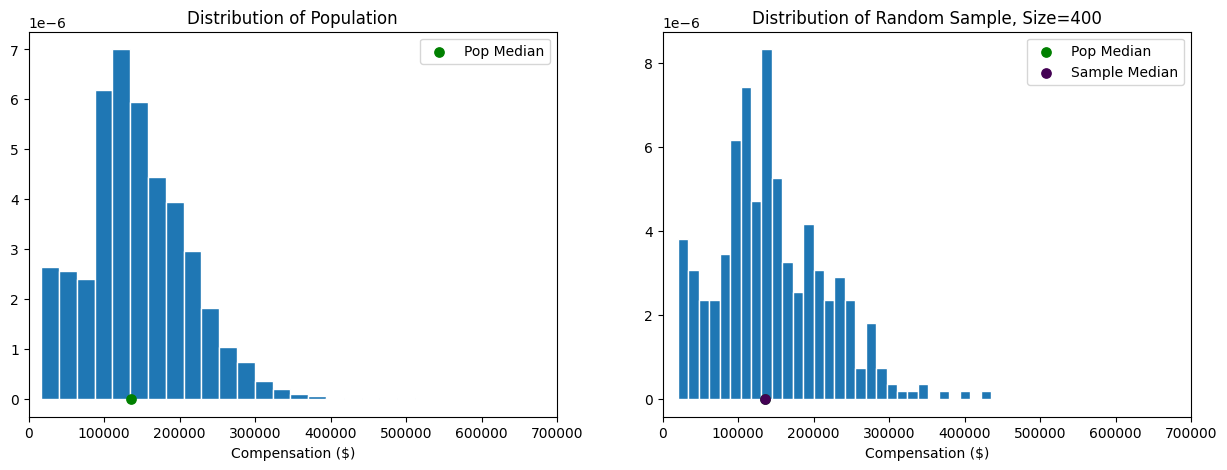

In [10]:


fig, ax = plt.subplots(1,2, figsize=(15,5))

# Population Parameter: Median Total Compensation 
pop_median = sf['Total Compensation'].median()
pop_median


ax[0].hist(sf["Total Compensation"],density=True, ec='white', bins=30);
ax[0].set_title("Distribution of Population")
ax[0].set_xlabel("Compensation ($)")
ax[0].set_xlim(0, 700000)
ax[0].scatter(pop_median, -.00000001, color="green", s=45, zorder=3, label="Pop Median");
ax[0].legend()


# Plot a sample of size 400



sample_median = orig_sample["Total Compensation"].median()

ax[1].hist(orig_sample["Total Compensation"],density=True, ec='white', bins=30);
ax[1].set_title("Distribution of Random Sample, Size="+str(sample_size))
ax[1].set_xlabel("Compensation ($)")
ax[1].set_xlim(0, 700000)
ax[1].scatter(pop_median, -.00000001, color="green", s=45, zorder=3, label="Pop Median");
ax[1].scatter(sample_median, -.00000001, c=1.5, s=45, zorder=3, label="Sample Median");
ax[1].legend()

print("Population median is:",pop_median, "and Median of our 1 Sample is:",sample_median )

However, our random sample *could have been different*. Then our estimate would have been different too. To see how different, we need another sample.


## Variability of the Estimator

In [11]:
def generate_sample_median(samp_size):
    new_sample = sf.sample(samp_size, replace=False)
    return new_sample["Total Compensation"].median()

In [12]:
generate_sample_median(400)

135697.0

## Quantifying Uncertainty:  Sampling Distribution of the Sample Median (using repeated samples from the population):

In [13]:
sample_medians= np.array([generate_sample_median(400) for i in range(1000)])

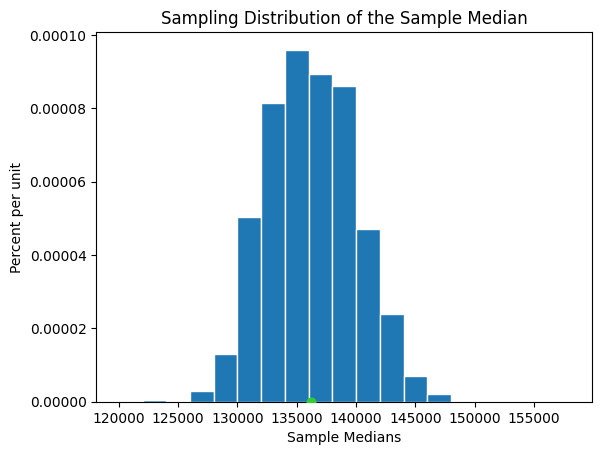

In [14]:
med_bins = np.arange(120000, 160000, 2000)
plt.hist(sample_medians,med_bins, density=True, ec='white');
plt.xlabel("Sample Medians")
plt.ylabel("Percent per unit")
plt.title("Sampling Distribution of the Sample Median")
parameter_green = '#32CD32'
plt.scatter(pop_median, 0, color=parameter_green, s=40, zorder=3);

### Problem!
But in the real world we won't be able to keep going back to the population to get new samples (it costs time and money). How to approximate the sampling distribution of the statistic without having to keep resampling the population?

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


# Bootstrapping the Sampling Distribution of the Statistic

- Sample randomly:
  - from the original sample
  - with replacement
  - the same number of times as the original sample size
 
- Compute the statistic using the bootstrapped sample:

In [15]:
# Here we load the (fictional) sample that was taken by Prof. Oscamou
# We are all going to use the same one sample for the next few steps so that 
# we get the same answer for this first demo:

sample_sf = pd.read_csv("sf_sample.csv")
sample_sf.head(5)

,Unnamed: 0,Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
0,30718,Community Health,Public Health,Human Services,Hospital Eligibility Worker,15746.0,230.0,1240.0,17216.0
1,26940,Community Health,Public Health,"Payroll, Billing & Accounting",Accountant III,111816.0,0.0,46250.0,158066.0
2,26746,Community Health,Public Health,Information Systems,IS Business Analyst-Principal,106571.0,0.0,17000.0,123570.0
3,22031,"Public Works, Transportation & Commerce",Public Utilities Commission,Supervisory-Labor & Trade,Sewer Repair Supervisor,145342.0,10646.0,49299.0,205287.0
4,9420,"Public Works, Transportation & Commerce",Airport Commission,Management,Manager IV,152315.0,0.0,58910.0,211225.0


In [2]:
def one_bootstrapped_statistic(sample, statistic):
    # Step 1: Sample the Sample WITH replacement
    bootstrap_sample = sample.sample(frac=1, replace=True)
        
    # Step 2: compute statistic on the sample of the sample
    bootstrap_stat = statistic(bootstrap_sample)
    
    return bootstrap_stat
    

- Repeat above steps **10,000** times and plot the distribution of the statistic

In [3]:
def bootstrapper(sample, statistic, num_repetitions=10000):
    """
    Returns the statistic computed on a num_repetitions  
    bootstrap samples from sample.
    """
    bstrap_stats = np.array([one_bootstrapped_statistic(sample,statistic) for i in np.arange(num_repetitions)])

    return bstrap_stats    

In [18]:
bootstrap_medians = bootstrapper(sample_sf, median_comp, 10000)

### Examining the Bootstrapped Distribution of the Statistic

When using the boostrap it is important to always plot the distribution of the statistic.  In general when using **the percentile bootstrapping method for calculating confidence intervals** we are looking for a distribution that is **roughly symmetric and bell-shaped**, in order for our L% confidence intervals to correctly contain the actual population parameter L% of the time.

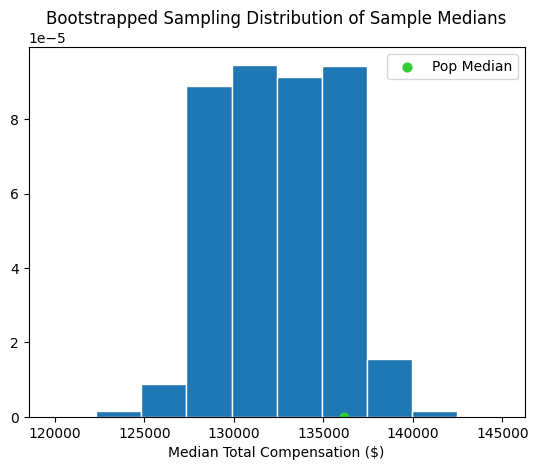

In [19]:
plt.hist(bootstrap_medians, density=True, ec='white');

parameter_green = '#32CD32'

plt.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2, label = "Pop Median")
plt.title('Bootstrapped Sampling Distribution of Sample Medians');
plt.xlabel('Median Total Compensation ($)')
plt.legend()
          
    

## Creating a L% Confidence Interval Using the Percentile Method:  Middle L% of the Bootstrap Estimates 

We compute the confidence interval for our desired **confidence level** using the following code:

In [4]:
def compute_ci(bs_samples, confidence_level):
    """
    Returns the confidence interval for the provided bootstrap samples
    and desired confidence level, using the percentile method.
    """
    tail_size = (100-confidence_level)/2
    lower, upper = np.percentile(bs_samples, [tail_size, 100-tail_size])
    return [lower, upper]

In [21]:
ci = compute_ci(bootstrap_medians, 95)
ci

[127160.0, 138148.5]

### Visualizing the Confidence Interval

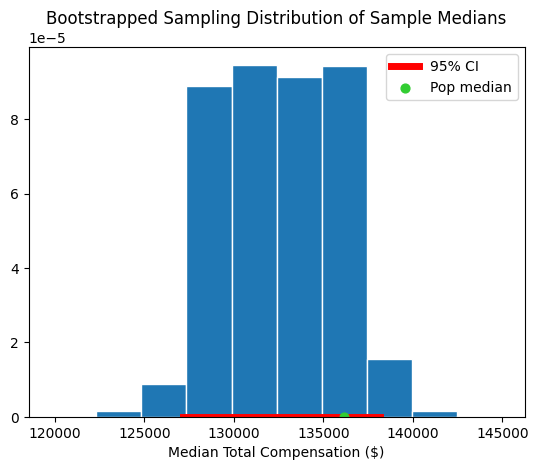

In [22]:
plt.hist(bootstrap_medians, density=True, ec='white');

# cool python trick to deconstruct the array!
[left, right] = compute_ci(bootstrap_medians, 95)

# Plotting CI 
plt.plot([left, right], [0, 0], color='red', lw=5, zorder=1, label = "95% CI")

# Plotting actual population median (usually unknown)
plt.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2, label = "Pop median");


plt.title('Bootstrapped Sampling Distribution of Sample Medians');
plt.xlabel('Median Total Compensation ($)')
plt.legend()

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


## Visualizing the Accuracy of Bootstrapped Percentile Confidence Intervals  
*** 

The function CI_test below allows us to repeat the entire process of creating a confidence interval from start to finish using a fresh random sample each time.

We can visualize the coverage of the bootstrapped confidence intervals at the 95% confidence level for the median of the Total Compensation.  Recall that you know that the true population median is `pop_median` = 136164

In [ ]:
def CI_test(sample_size, pop_median, num_CIs, num_boots, conf_level=95):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
    
    
    ax.plot([pop_median, pop_median],[0,num_CIs],  color="green", ls='--', lw=3, label = "Pop Median")
       # Horizontal line marking the mean
        
    for jj in range(num_CIs):
        # Take a random sample:
        sample1=sf.sample(sample_size,replace=False)
        
        bootstrap_med1 = bootstrapper(sample1, median_comp, 10000)
        
        # Calculate the bootstrapped CI for that sample
        L, U = compute_ci(bootstrap_med1, conf_level)
        CI = np.array([L, U])
        ax.plot([L, U],[jj, jj])
        
        
            
        
    ax.set_ylim([-1,num_CIs+1])
    plt.yticks(range(num_CIs), fontsize=12)
    plt.xlabel("Total Compensation ($)")
    plt.ylabel("20 different Confidence Intervals from 20 different samples")
    plt.title("Examples of " + str(conf_level)+ "% Bootstrapped Confidence Intervals for Population Median")
    ax.legend()
        
CI_test(400, pop_median,num_CIs=20, num_boots=10000, conf_level=95)
# Call the function

---

## Changing Confidence Level - Effect on Confidence Intervals

In [ ]:
plt.hist(bootstrap_medians, density=True, ec='white');


[left1, right1] = compute_ci(bootstrap_medians, 95)


[left2, right2] = compute_ci(bootstrap_medians, 80)

# Plotting CI 
plt.plot([left1, right1], [0, 0], color='red', lw=5, zorder=1, label = "95% CI")
plt.plot([left2, right2], [-0.000001, -.000001], color='orange', lw=5, zorder=1, label = "90% CI")


# Plotting actual population median (usually unknown)
plt.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2, label = "Pop median");


plt.title('Bootstrapped Sampling Distribution of Sample Medians');
plt.xlabel('Median Total Compensation ($)')
plt.legend()

---

## Changing Sample Sizes - Effect on Confidence Intervals

The results we saw above were dependent on our sample distribution accuractely representing the population distribution.  This is only the case if we take a random sample and if it's large enough. 

Let's look at what happens if we use smaller sample sizes.   How accurate are our 95% Bootstrap Estimates of the Parameter for different sample sizes? 

In [ ]:
intervals = pd.DataFrame(columns = ['lower', 'upper', 'median', 'good', 'sample size' ])

sample_sizes = [2,8,16,50, 100]
for sample_size in sample_sizes:
    for trial in np.arange(20): # Run 20 trials of each configuration
        # Pay for one new random sample from the population
        og_sample = sf.sample(sample_size, replace=False)
        
        # Compute the statistic on the sample
        sample_median = median_comp(og_sample)
        
        # Generate the medians of 10000 bootstrap samples
        bootstrap_medians = bootstrapper(og_sample, median_comp, 10000)
        
        # Construct the confidence interval
        [ci_lower, ci_upper] = compute_ci(bootstrap_medians, 95)
        
        # Determine if the confidence interval is good (i.e. does it actually contain the population parameter)
        is_good = ci_lower <= pop_median <= ci_upper
        
        # Add a row with this data to the DataFrame
        
        intervals.loc[len(intervals.index)] = [ci_lower, ci_upper, sample_median, is_good, str(sample_size)]
    

        

# Add an experiment number
intervals["Experiment"]= np.arange(intervals.shape[0])

In [ ]:
intervals

Here we render a plot of all the confidence intervals with the true value depicted as a solid vertical line.  

In [ ]:
import plotly.express as px

# Plotly will draw error bars which are the distance in each direction
# from the median
intervals["error_left"] = intervals["median"]-intervals["lower"]
intervals["error_right"] = intervals["upper"]-intervals["median"]


# Making the plot
fig = px.scatter(
    x=intervals["median"], # X location of my interval center dot
    y=intervals["Experiment"], # Y location of my interval center dot 
    color=intervals["sample size"], # The color to use.
    symbol=intervals["good"], # The column to use for the symbol
    symbol_map={True: "circle", False: "circle-open"},
    error_x=intervals["error_right"], # upper error bar size
    error_x_minus=intervals["error_left"], # lower error bar size
    height=800)
fig.add_vline(pop_median)
#ax.title("95% Confidence Intervals for Different Sample Sizes")

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


## Confidence Interval for Unknown Population Mean

Now let's look at a more appropriate use of the bootstrap (when we don't have the population).  The baby data from our prior lectures had a random sample of moms.

In [5]:
# Random sample of mother-newborn pairs
births = pd.read_csv('baby.csv')
births.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


What is the average age of moms who are having children in the entire population?

**Parameter:** Average age of moms when they give birth to first child.

**Statistic:** Average age of moms in our sample.

In [6]:
# Average age of mothers in the sample
births['Maternal Age'].mean()

27.228279386712096

Remember there was a distribution of ages in the sample.

Text(0.5, 1.0, "Distribution of Mother's Age in our SAMPLE")

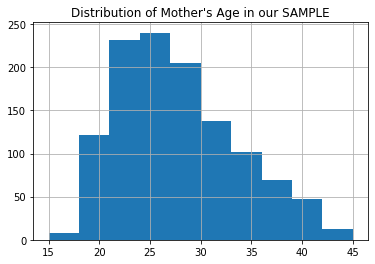

In [7]:
births.hist('Maternal Age')
plt.title("Distribution of Mother's Age in our SAMPLE")


### Compute the Sample Statistic
Since we are interested in estimating the average age of mothers in the population we will use the average age statistic:

In [8]:
def avg_maternal_age(sample):
    return sample["Maternal Age"].mean()

In [9]:
sample_statistic = avg_maternal_age(births)
sample_statistic

27.228279386712096

### Use the Bootstrap to Estimate the CI 

The interval of estimates is the "middle 95%" of the bootstrap estimates.

This is called a *95% confidence interval* for the **mean age in the population**.


In [10]:
bootstrap_means = bootstrapper(births, avg_maternal_age, 10000)
avg_maternal_age_ci = compute_ci(bootstrap_means, confidence_level=95)
avg_maternal_age_ci

[26.903747870528107, 27.56047700170358]

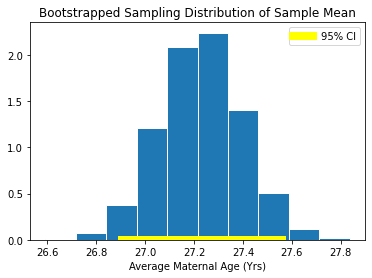

In [11]:
plt.hist(bootstrap_means, density=True, ec='white');


[left, right] = avg_maternal_age_ci
plt.plot([left, right], [0, 0], color='yellow', lw=8, label = "95% CI");
plt.title("Bootstrapped Sampling Distribution of Sample Mean")
plt.xlabel("Average Maternal Age (Yrs)")
plt.legend()


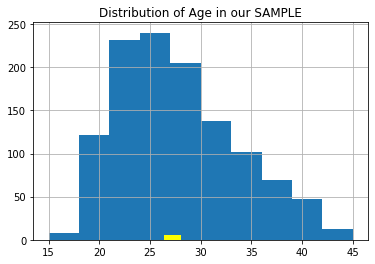

In [12]:
# Now we can visualize this interval back on our sample
# Notice tiny yellow bar at the bottom:
births.hist('Maternal Age')
plt.title("Distribution of Age in our SAMPLE")

plt.plot([left, right], [0, 0], color='yellow', lw=10);

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


## Using the Confidence Interval for Testing Hypotheses

**Null:** The average age of mothers in the population is 25 years; the random sample average is different due to chance.

**Alternative:** The average age of the mothers in the population is **not** 25 years.

Suppose you use the 5% cutoff for the p-value.

Based on the confidence interval, which hypothesis would you pick?

In [13]:
bootstrap_means = bootstrapper(births, avg_maternal_age, 10000)
avg_maternal_age_ci = compute_ci(bootstrap_means, confidence_level=95)
avg_maternal_age_ci

[26.902874787052813, 27.551980408858604]

Conclusion:  

Suppose instead you use the 1% cutoff for the p-value.


In [14]:
bootstrap_means = bootstrapper(births, avg_maternal_age, 10000)
avg_maternal_age_ci = compute_ci(bootstrap_means, confidence_level=99)
avg_maternal_age_ci

[26.808343270868825, 27.67291737649063]

Conclusion:  

check it: https://www.cdc.gov/nchs/nsfg/key_statistics/b.htm

<br><br><br><br>

---

Return to Slides

---

<br><br><br><br>


## Method Based on CLT to calculate CI for Age

In [19]:
sampled_ages = births['Maternal Age']
sample_size = len(sampled_ages)
sample_average = np.average(sampled_ages)


print(f"Sample Size: {sample_size}")
print(f"Sample Average Age: {sample_average}")


Sample Size: 1174
Sample Average Age: 27.228279386712096


## Approximating the confidence interval

We need to add $2 \cdot ( \frac{\text{Population SD}}{\sqrt{\text{Sample_Size}}})$ on one side and subtract it on the other side to get the confidence interval but we don't have the population SD.

In [16]:
# Try estimating it from the sample

sample_SD = np.std(sampled_ages,ddof=1) 
#The parameter ddof=1 ensures that you're 
#calculating the std for a sample, not a population
print(f"Sample Std Dev: {sample_SD}")


estimated_SE_of_sample_average = sample_SD / (sample_size**0.5)
print(f"Estimated Std Error: {estimated_SE_of_sample_average}")

Sample Std Dev: 5.817838716855792
Estimated Std Error: 0.16979606801968558


In [17]:
# Approximate 95% confidence interval for population mean

sample_average - 2*estimated_SE_of_sample_average, sample_average + 2*estimated_SE_of_sample_average

(26.888687250672724, 27.567871522751467)

In [20]:
#Compare this to the bootstrapped results we got above:
avg_maternal_age_ci

[26.808343270868825, 27.67291737649063]